In [1]:
# %%
import time
import argparse
import logging
from tqdm import tqdm
import pandas as pd
from attrdict import AttrDict
from collections import defaultdict
from scipy.stats import gmean
import numpy as np
import random
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
from imbalanced_regression.qsm.lassonet import lassonet
from imbalanced_regression.qsm import loss
from imbalanced_regression.qsm.datasets import QSM_features
from imbalanced_regression.utils import *
from imbalanced_regression.qsm.fds import FDS
import util
from util import pyvis, model_scale
import sklearn.model_selection as sks
import sklearn.metrics as skm
import sklearn.feature_selection as skf
import os
import nibabel as nib
from IPython.display import HTML
from datetime import datetime
import matplotlib.pyplot as plt
os.environ["KMP_WARNINGS"] = "FALSE"


In [2]:
# Get case IDs
case_list = open('/home/ali/RadDBS-QSM/data/docs/cases_90','r')
lines = case_list.read()
lists = np.loadtxt(case_list.name,comments="#", delimiter=",",unpack=False,dtype=str)
case_id = []
for lines in lists:     
    case_id.append(lines[-9:-7])

# Load scores
file_dir = '/home/ali/RadDBS-QSM/data/docs/QSM anonymus- 6.22.2023-1528.csv'
motor_df = util.filter_scores(file_dir,'pre-dbs updrs','stim','CORNELL ID')
# Find cases with all required scores
subs,pre_imp,post_imp,pre_updrs_off = util.get_full_cases(motor_df,
                                                          'CORNELL ID',
                                                          'OFF (pre-dbs updrs)',
                                                          'ON (pre-dbs updrs)',
                                                          'OFF meds ON stim 6mo')
# Find overlap between scored subjects and nii
ids = np.asarray(case_id).astype(int)
# ids = ids[ids != 54]
cases_idx = np.in1d(subs,ids)
ccases = subs[cases_idx]
per_change = np.round(post_imp[cases_idx],1)

nii_paths = []
per_change_match = []
updrs_match = []
qsm_dir = '/home/ali/RadDBS-QSM/data/npy/X/'
qsm_niis = sorted(os.listdir(qsm_dir))
for k in np.arange(len(ccases)):
    for file in qsm_niis:
        if int(ccases[k]) == int(file[4:6]):
            nii_paths.append(qsm_dir+file)
            per_change_match.append(per_change[k])
            updrs_match.append(pre_updrs_off[k])

train_dir, test_dir, y_train, y_test, pre_train, pre_test = sks.train_test_split(nii_paths, 
                                                                                 per_change_match, 
                                                                                 updrs_match, 
                                                                                 test_size=0.1,
                                                                                 random_state=2)
train_dir, val_dir, y_train, y_val, pre_train, pre_val = sks.train_test_split(train_dir, 
                                                                              y_train, 
                                                                              pre_train, 
                                                                              test_size=0.2, 
                                                                              random_state=2)

In [3]:
args = AttrDict()
args.gpu = 0
args.optimizer = 'sgd'
args.lr = 1e-3
args.epoch = 100
args.momentum = 0.9
args.weight_decay = 1e-4
args.schedule = [60,80]
args.print_freq = 10
args.resume = ''
args.pretrained = False
args.evaluate = False
args.loss = 'l1'
args.dataset = 'qsm'
args.model = 'resnet50'
args.store_root = '/home/ali/RadDBS-QSM/data/checkpoint'
args.data_dir = '/home/ali/RadDBS-QSM/data/qsm/'
args.fds = True
args.fds_kernel = 'gaussian'
args.fds_ks = 5
args.fds_sigma = 1
args.fds_mmt = 0.9
args.start_update = 0
args.start_smooth = 0
args.bucket_num = 5
args.bucket_start = 0
args.start_epoch = 0
args.best_loss = 1e5
args.reweight = 'sqrt_inv'
args.retrain_fc = False
args.lds = True
args.lds_kernel = 'gaussian'
args.lds_ks = 3
args.lds_sigma = 1
args.batch_size = len(y_train)
args.workers = 24
args.input_type = 'features'
args.store_name = 'L_'+str(args.loss)+'_FDS_'+str(args.fds)+'_LDS_'+str(args.lds)+'_BS_'+str(args.batch_size)+'_IT_'+str(args.input_type)+'_'+str(datetime.now())


In [4]:
 # Data
print('=====> Preparing data...')

train_dataset = QSM_features(data_dir=train_dir, targets=y_train, pre_metric=pre_train, scaler_ss=None, split='train',
                        reweight=args.reweight, lds=args.lds, lds_kernel=args.lds_kernel, lds_ks=args.lds_ks, lds_sigma=args.lds_sigma)
val_dataset = QSM_features(data_dir=val_dir, targets=y_val, pre_metric=pre_val, scaler_ss=train_dataset.__getscaler__(), split='val')
test_dataset = QSM_features(data_dir=test_dir, targets=y_test, pre_metric=pre_test, scaler_ss=train_dataset.__getscaler__(), split='test')

train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True,
                            num_workers=args.workers, pin_memory=True, drop_last=False)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False,
                        num_workers=args.workers, pin_memory=True, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False,
                            num_workers=args.workers, pin_memory=True, drop_last=False)
print(f"Training data size: {len(train_dataset)}")
print(f"Validation data size: {len(val_dataset)}")
print(f"Test data size: {len(test_dataset)}")
print(y_test)

=====> Preparing data...
Using re-weighting: [SQRT_INV]
Using LDS: [GAUSSIAN] (3/1)
Training data size: 33
Validation data size: 9
Test data size: 5
[0.8, 0.2, 0.2, 0.5, 0.7]


In [5]:
smoothed_dist,original_dist = train_dataset.__getslabels__()

Text(0.5, 1.0, 'Smoothed label distribution')

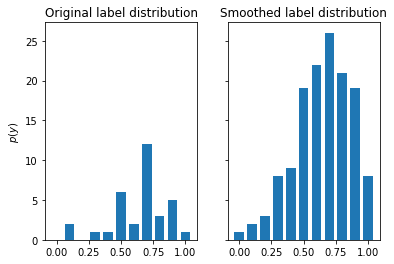

In [6]:
fig,ax = plt.subplots(1,2,sharex=True,sharey=True)
ax[0].bar(x=np.linspace(0,1,11),height=original_dist,width=0.075)
ax[0].set_title('Original label distribution')
ax[0].set_ylabel(r'$p(y)$')
ax[1].bar(x=np.linspace(0,1,11),height=smoothed_dist,width=0.075)
ax[1].set_title('Smoothed label distribution')


In [7]:
X = np.zeros((len(y_train),9576))
y = np.zeros((len(y_train)))
for j in np.arange(len(y_train)):
    X0, y0, _ = train_dataset[j]
    X[j,:] = np.squeeze(X0)
    y[j] = y0
sel = skf.SelectKBest(skf.r_regression,k=10)
X = torch.tensor(sel.fit_transform(np.squeeze(np.asarray(X)),y))

/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


In [27]:
f = FDS(feature_dim=X.shape[1], bucket_num=args.bucket_num, 
        bucket_start=args.bucket_start,
        start_update=args.start_update, 
        start_smooth=args.start_smooth, 
        kernel=args.fds_kernel, ks=args.fds_ks, sigma=args.fds_sigma, momentum=args.fds_mmt)

In [28]:
Xs = X
for k in np.arange(args.epoch):
    Xs = f.smooth(features=torch.tensor(Xs),labels=torch.tensor(y),epoch=k)
    print(np.sum((np.asarray(Xs)-X)**2))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [29]:
# Assign the anchor target to the median
anchor = np.min(y)
arr1inds = np.asarray(y).argsort()
X = np.asarray(X)[arr1inds]
y = np.asarray(y)[arr1inds]
aj = np.where(y==anchor)
aj = aj[0][0]

In [30]:
C0 = np.zeros((1,len(y))).T
C0_s = np.zeros((1,len(y))).T
for j in np.arange(len(y)):
    C0[j] = skm.pairwise.cosine_similarity(np.squeeze(X[aj,:]).reshape(1, -1),
                                           np.squeeze(X[j,:]).reshape(1, -1))
    C0_s[j] = skm.pairwise.cosine_similarity(np.squeeze(Xs[aj,:]).reshape(1, -1),
                                           np.squeeze(Xs[j,:]).reshape(1, -1))

Text(0.5, 1.0, 'Standard')

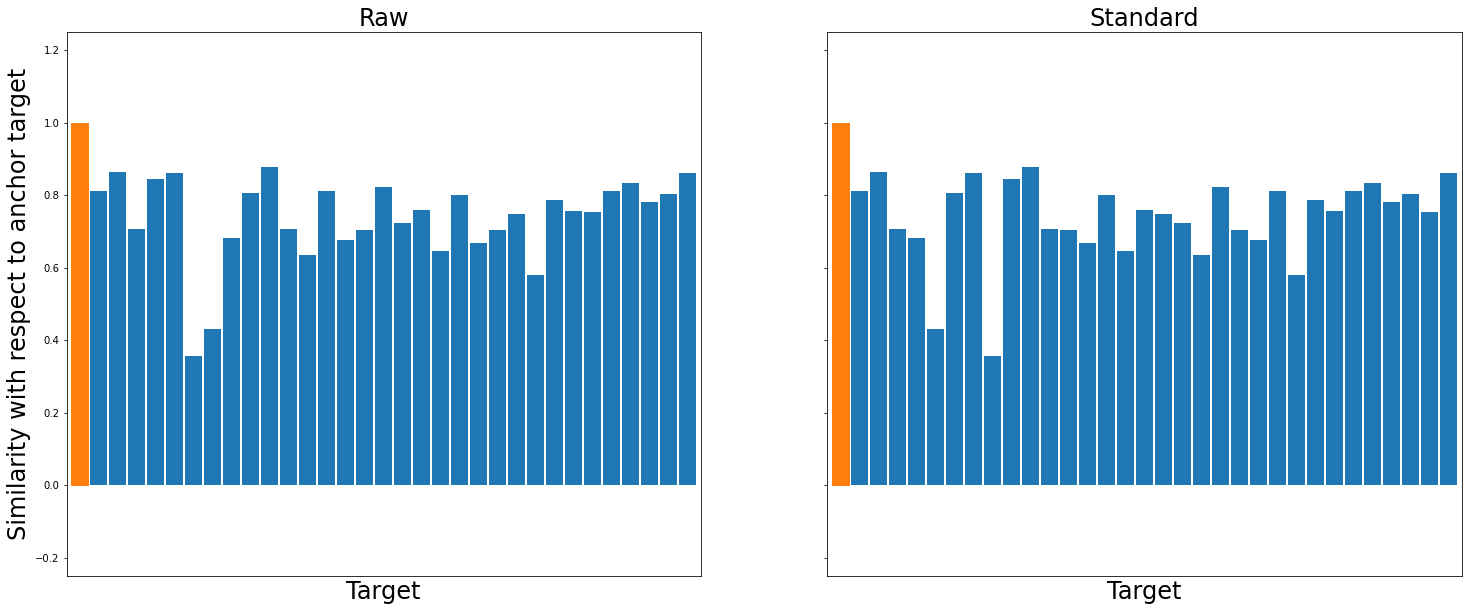

In [31]:
fig, ax = plt.subplots(1,2,figsize=(25,10),sharey=True)
pd.DataFrame(C0,index=np.sort(y)).plot.bar(ax=ax[0],legend=False,width=0.9)
ax[0].set_xticks([])
ax[0].get_children()
ax[0].get_children()[aj].set_color('#ff7f0e') 
ax[0].set_ylim([-0.25,1.25])
ax[0].set_ylabel('Similarity with respect to anchor target',fontsize=24)
ax[0].set_xlabel('Target',fontsize=24)
ax[0].set_title('Raw',fontsize=24)
pd.DataFrame(C0_s,index=np.sort(y)).plot.bar(ax=ax[1],legend=False,width=0.9)
ax[1].set_xticks([])
ax[1].get_children()
ax[1].get_children()[aj].set_color('#ff7f0e') 
ax[1].set_xlabel('Target',fontsize=24)
ax[1].set_title('Standard',fontsize=24)
